In [2]:
import os
import json

from dataclasses import dataclass
from collections import Counter

import gensim
import nltk
import torch
import torchmetrics

import numpy as np
import pandas as pd
import seaborn as sns

from torch import nn
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

# Setup

- **Word level vocab can ge generated from the tokenization notebook**

In [ ]:
data_dir = os.path.join(os.curdir, "data")
vocab_path = os.path.join(data_dir, "word-level-vocab.json")
ara2vec_path = os.path.join(data_dir, "full_grams_cbow_100_twitter", "full_grams_cbow_100_twitter.mdl")

with open(vocab_path, "rt") as f:
    vocab = json.load(f)
    
dataset = pd.read_csv(filepath_or_buffer=dataset_path, sep="\t")


ChunkedEncodingError: ('Connection broken: IncompleteRead(1920144240 bytes read, 913542172 more expected)', IncompleteRead(1920144240 bytes read, 913542172 more expected))

In [4]:
tweets = dataset["clean_text"].tolist()

In [5]:
OOV_TOKEN = "[OOV]"
PAD_TOKEN = "[PAD]"

OOV_INDEX = vocab.get(OOV_TOKEN)

print(f"Vocab Size = {len(vocab)}")

Vocab Size = 10998


In [6]:
tokenized_tweets = [[vocab.get(token) for token in tweet.split(" ") if token in vocab] for tweet in tweets]

In [7]:
device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
device

device(type='mps')

# Dataset

## filter dataset for empty and long sequences

In [8]:
# Tweets that are empty (all tokens appear less than the minimum frequency)
len([len(tweet) for tweet in tokenized_tweets if len(tweet) == 0])

0

In [9]:
# Max Tweet length
max([len(tweet) for tweet in tokenized_tweets])

72

In [10]:
# 99th percentile of tweets' lengths
np.percentile([len(tweet) for tweet in  tokenized_tweets], q=99)

23.0

In [11]:
# Filtered Tweets indices by length
MIN_LENGTH = 0
MAX_LENGTH = np.percentile([len(tweet) for tweet in  tokenized_tweets], q=99)
filtered_indices = [index for index, tweet in enumerate(tokenized_tweets) if len(tweet) < MAX_LENGTH and len(tweet) > MIN_LENGTH]

In [12]:
X = nn.utils.rnn.pad_sequence([torch.tensor(tweet) for tweet in tokenized_tweets],
                              batch_first=True,
                              padding_value=vocab.get(PAD_TOKEN))

In [13]:
y = torch.tensor(dataset["Sentiment"].replace({"negative": 0, "neutral": 1, "positive": 2}).to_numpy())

/var/folders/tg/jhy0d12925ldvjghgc440mjh0000gn/T/ipykernel_87871/942548510.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = torch.tensor(dataset["Sentiment"].replace({"negative": 0, "neutral": 1, "positive": 2}).to_numpy())


In [14]:
X, y = X[filtered_indices], y[filtered_indices]

In [15]:
BATCH_SIZE = 16

## split training and testing set

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.15)

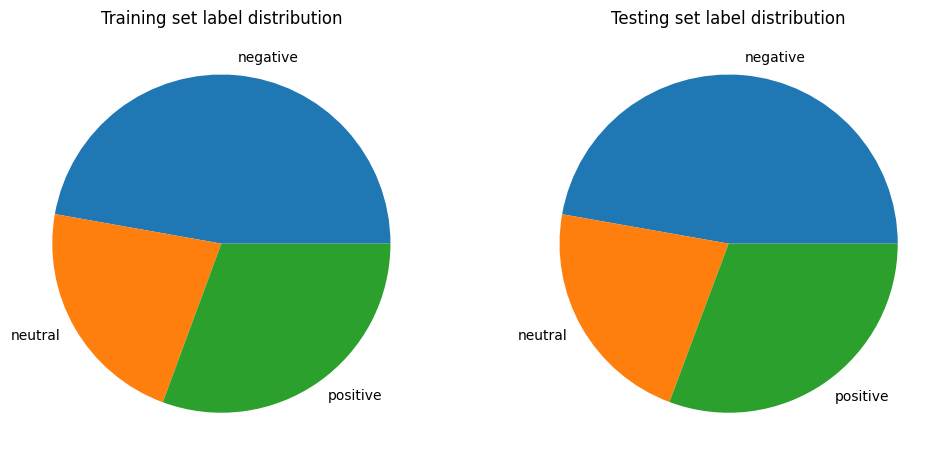

In [17]:
fig, (ax1, ax2) = plt.subplots(figsize=(12, 10), ncols=2)

train_dist = np.unique(y_train, return_counts=True)
test_dist = np.unique(y_test, return_counts=True)
labels = ["negative", "neutral", "positive"]

ax1.pie(x=train_dist[1], labels=labels)
ax2.pie(x=test_dist[1], labels=labels)

ax1.set_title("Training set label distribution")
ax2.set_title("Testing set label distribution")

plt.show()

## prepare PyTorch datasets and dataloaders

In [18]:
train_dataset = torch.utils.data.TensorDataset(X_train, y_train)
test_dataset = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Model

In [19]:
class SentimentAnalyzer(nn.Module):
    def __init__(
        self, 
        vocab_size: int,
        latent_dim: int,
        embedding_dim:int,
        dropout: float = 0.3,
        padding_idx: int = 0
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.padding_idx = padding_idx
        self.latent_dim = latent_dim
        
        self.embedding = nn.Embedding(num_embeddings=self.vocab_size, 
                                      embedding_dim=self.embedding_dim, 
                                      padding_idx=self.padding_idx, 
                                      max_norm=1.0)
        
        self.rnn = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.latent_dim,
            batch_first=True,
            num_layers=1,
            bidirectional=True
        )
        
        
        self.fc1 = nn.Linear(in_features=self.latent_dim * 2, out_features=3)
        self.dropout = nn.Dropout(p=dropout) 

        
    
    def forward(self, x):
        # x = (batch_size, sequence_length) 
        
        embeddings = self.embedding(x)       
        embeddings = self.dropout(embeddings)
        # embeddings = (batch_size, sequence_length, embedding_dim)
        
        hidden_states, (last_hidden_state, last_cell_state) = self.rnn(embeddings)
        
        output = torch.concat([last_hidden_state[-1,:,:], last_hidden_state[-2,:,:]], dim=-1) 
        # output = (batch_size, latent_dim * 2)
        output = self.dropout(output)
        
        output = self.fc1(output)      
        
        return output
        
    

In [20]:
EMBEDDING_DIM = 16
LATENT_DIM = 8
DROPOUT = 0.25

In [21]:
model = SentimentAnalyzer(
    vocab_size=len(vocab),
    latent_dim=LATENT_DIM,
    embedding_dim=EMBEDDING_DIM,
    dropout=DROPOUT
).to(device)

# Training

In [22]:
EPOCHS = 30
LR = 5e-4

optim = torch.optim.Adam(params=model.parameters(), lr=LR)
criterion = nn.CrossEntropyLoss()

train_metric = torchmetrics.F1Score(task="multiclass",num_classes=3).to(device)
val_metric = torchmetrics.F1Score(task="multiclass",num_classes=3).to(device)

In [23]:
# A dataclass object defined to store the loss and metric results of each epoch
# REFERENCE: https://realpython.com/python-data-classes/
@dataclass
class Epoch:
    epoch: int
    training_loss: float
    validation_loss: float
    training_acc: float
    validation_acc: float
        
    
    def log(self) -> None:
        print(f"Epoch {self.epoch + 1}: Training Loss: {self.training_loss}\tValidation Loss: {self.validation_loss} || Training F1: {self.training_acc}\tValidation F1: {self.validation_acc}\n----------------------------------------------------")

In [24]:
history: list[Epoch] = []

for epoch in range(EPOCHS):
    # Define epoch train and test: loss and metrics
    # Make sure to reset the metric function
    epoch_train_loss = 0
    epoch_val_loss = 0
    
    train_metric.reset()
    val_metric.reset()
    
    # TODO: Set the model to training mode
    model.train()
    # Iterate train batches
    for batch in train_dataloader:
        
        # REMEMBER: you need to reset the optimizer in order to avoid incorrect accumulation of gradientrs 
        optim.zero_grad()
        
        # Unpack the batch and move it to the correct device
        inputs, target = batch
        inputs, target = inputs.to(device), target.to(device)

        # get prediction from model
        predictions = model(inputs)
        
        # Calculate loss and metric
        
        loss = criterion(predictions, target)
        train_metric(predictions, target)
        
        # Backward propagataion
        loss.backward()
        optim.step()
        
        # Accumulate train loss
        epoch_train_loss += loss.item()
    
    # Calculate epoch training metric
    epoch_train_f1 = round(train_metric.compute().item(), 3)

    
    # TODO: set the model to test mode
    model.eval()
    # Reset the metric function
    # Make sure PyTorch will run inference without tracking gradients for enhancing performance
    with torch.no_grad():
        # Load batches from `test_loader`
        for batch in test_dataloader:
            
            # Unpack the batch and move it to the correct device
            inputs, target = batch
            inputs, target = inputs.to(device), target.to(device)

            # get prediction from model
            predictions = model(inputs)
            # Calculate loss and metric values
            loss = criterion(predictions, target)
            val_metric(predictions, target)
            
            # Accumulate validation loss
            epoch_val_loss += loss.item()
            
        # Calculate epoch validation metric
        epoch_val_f1 = round(val_metric.compute().item(), 3)
      

    # Calculate epoch training loss
    epoch_train_loss = round(epoch_train_loss / len(train_dataloader), 3)
    # Calculate epoch validation loss
    epoch_val_loss = round(epoch_val_loss / len(test_dataloader), 3)
    
    # Create `Epoch` instance with the results
    epoch_result = Epoch(epoch=epoch, 
                         training_loss=epoch_train_loss, 
                         validation_loss=epoch_val_loss,
                         training_acc=epoch_train_f1,
                         validation_acc=epoch_val_f1,
                        )
    
    # Add to history list
    history.append(epoch_result)
    # Log epoch output
    epoch_result.log()

/Users/anas/PythonProjects/PyTorch-learning/pytorch/lib/python3.12/site-packages/torch/nn/functional.py:2151: UserWarning: The operator 'aten::embedding_renorm_' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  torch.embedding_renorm_(weight.detach(), input, max_norm, norm_type)


Epoch 1: Training Loss: 1.089	Validation Loss: 1.049 || Training F1: 0.381	Validation F1: 0.472
----------------------------------------------------
Epoch 2: Training Loss: 1.053	Validation Loss: 1.059 || Training F1: 0.474	Validation F1: 0.472
----------------------------------------------------
Epoch 3: Training Loss: 1.043	Validation Loss: 1.047 || Training F1: 0.472	Validation F1: 0.472
----------------------------------------------------
Epoch 4: Training Loss: 1.009	Validation Loss: 0.979 || Training F1: 0.493	Validation F1: 0.499
----------------------------------------------------
Epoch 5: Training Loss: 0.904	Validation Loss: 0.897 || Training F1: 0.58	Validation F1: 0.548
----------------------------------------------------
Epoch 6: Training Loss: 0.827	Validation Loss: 0.873 || Training F1: 0.635	Validation F1: 0.575
----------------------------------------------------
Epoch 7: Training Loss: 0.754	Validation Loss: 0.889 || Training F1: 0.668	Validation F1: 0.594
-----------

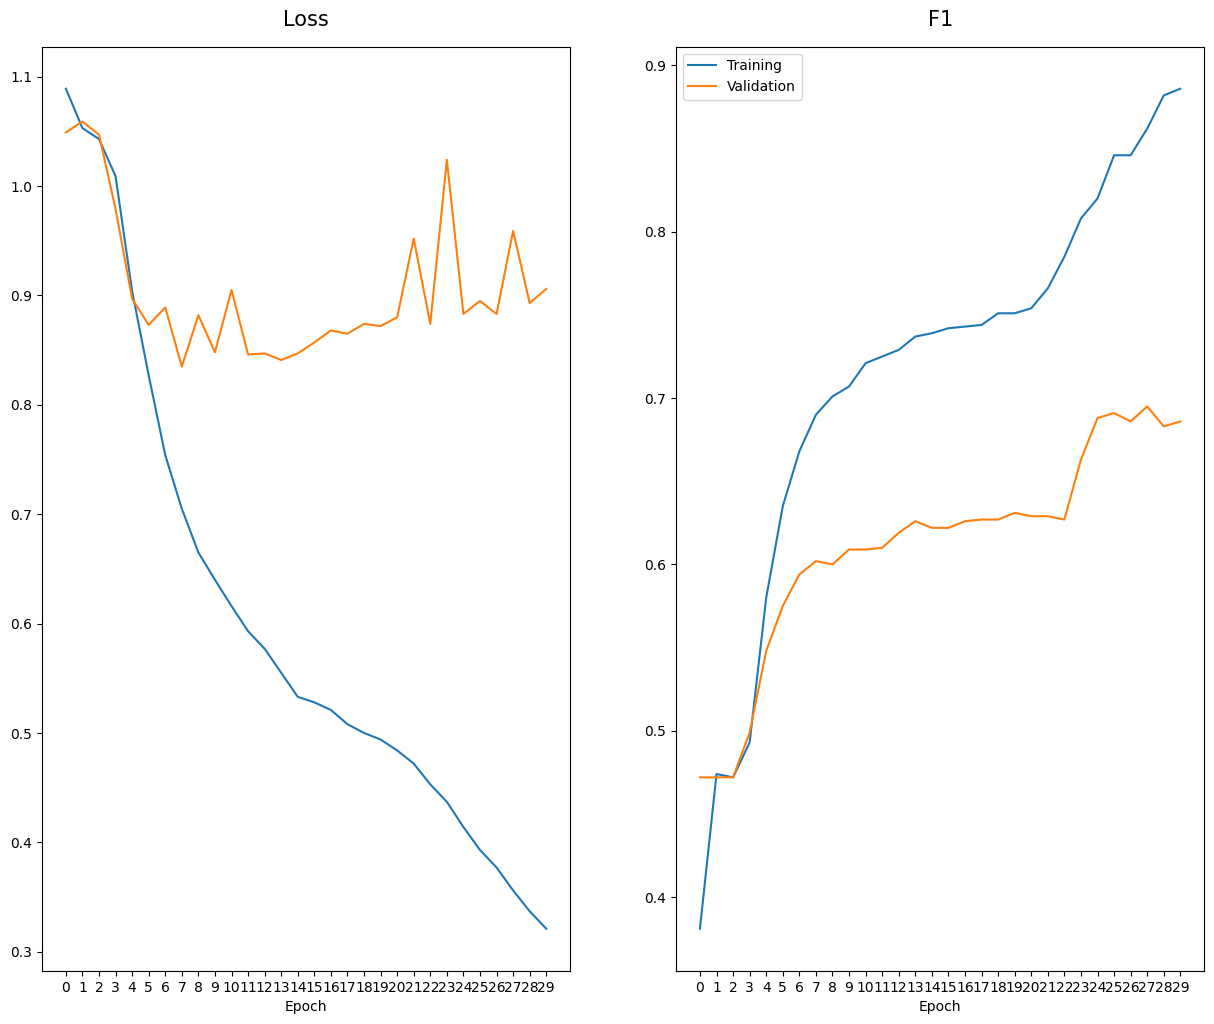

In [25]:
train_loss = list(map(lambda x: x.training_loss ,history))
val_loss = list(map(lambda x: x.validation_loss ,history))
train_acc = list(map(lambda x: x.training_acc, history))
val_acc = list(map(lambda x: x.validation_acc, history))


fig, (ax1, ax2) = plt.subplots(figsize=(15, 12), ncols=2)

ax1.plot(range(EPOCHS), train_loss, label="Training")
ax1.plot(range(EPOCHS), val_loss, label="Validation")

ax2.plot(range(EPOCHS), train_acc, label="Training")
ax2.plot(range(EPOCHS), val_acc, label="Validation")

ax1.set_title("Loss", fontdict=dict(size=15), pad=15)
ax2.set_title("F1", fontdict=dict(size=15), pad=15)

ax1.set_xticks(range(EPOCHS))
ax2.set_xticks(range(EPOCHS))

ax1.set_xlabel("Epoch")
ax2.set_xlabel("Epoch")

plt.legend()
plt.show()

# Summary

As seen in the training history plot, the models suffers from overfitting, this can be due to the model complexity or the inseprability of the data.

# Exercises

- Use pretrained embeddings (eg: AraVec)
- Try different parameters (eg: number of layers, latent dimension, ..etc)
- Train a statistical ML model (eg: naive bayes, KNN, ..etc)